In [1]:
import scanpy as sc
import gseapy as gp
import matplotlib.pyplot as plt
import gseapy as gp
import anndata as ad
import decoupler
from pathlib import Path

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
split = 3

In [3]:
adata_pred_ood = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_ood_with_predictions_{split}.h5ad")
#adata_pred_test = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_test_with_predictions_{split}.h5ad")

In [4]:
adata_pred_ood.X = adata_pred_ood.layers["X_recon_pred"]
adata_pred_ood.X[adata_pred_ood.X<0] = 0 
#adata_pred_test.X = adata_pred_test.layers["X_recon_pred"]

In [5]:
adata_train_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_train_{split}.h5ad"
adata_test_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_test_{split}.h5ad"
adata_ood_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_{split}.h5ad"

In [6]:
adata_train = sc.read(adata_train_path)
adata_test = sc.read(adata_test_path)
adata_ood = sc.read(adata_ood_path)

In [7]:
adata_pred_ood = adata_pred_ood[adata_pred_ood.obs["condition"]!="control"]

In [8]:
adata_pred_ood.var_names = adata_ood.var_names
#adata_pred_test.var_names = adata_test.var_names

In [9]:
adata_pred_ood.obs["condition"] = adata_pred_ood.obs.apply(lambda x: x["condition"] + "_pred", axis=1)

In [10]:
adata_full = ad.concat((adata_train, adata_ood, adata_pred_ood))

In [11]:
if not Path("c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O 'c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

In [12]:
import pandas as pd
def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )



In [13]:
reactome = gmt_to_decoupler("c2.cp.reactome.v7.5.1.symbols.gmt")

In [14]:
# Retrieving via python
msigdb = decoupler.get_resource("MSigDB")

# Get reactome pathways
reactome = msigdb.query("collection == 'reactome_pathways'")
# Filter duplicates
reactome = reactome[~reactome.duplicated(("geneset", "genesymbol"))]


  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/connectionpool.py", line 466, in _make_request
    self._validate_conn(conn)
  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/connectionpool.py", line 1095, in _validate_conn
    conn.connect()
  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/connection.py", line 652, in connect
    sock_and_verified = _ssl_wrap_socket_and_match_hostname(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/connection.py", line 805, in _ssl_wrap_socket_and_match_hostname
    ssl_sock = ssl_wrap_socket(
               ^^^^^^^^^^^^^^^^
  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/util/ssl_.py", line 465, in ssl_wrap_socket
    ssl_sock = _ssl_wrap_socket_impl(sock, context, tls_in_tls, server_hostnam

In [15]:
sc.tl.rank_genes_groups(adata_full, "condition", method="t-test", key_added="t-test", reference="control")

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_g

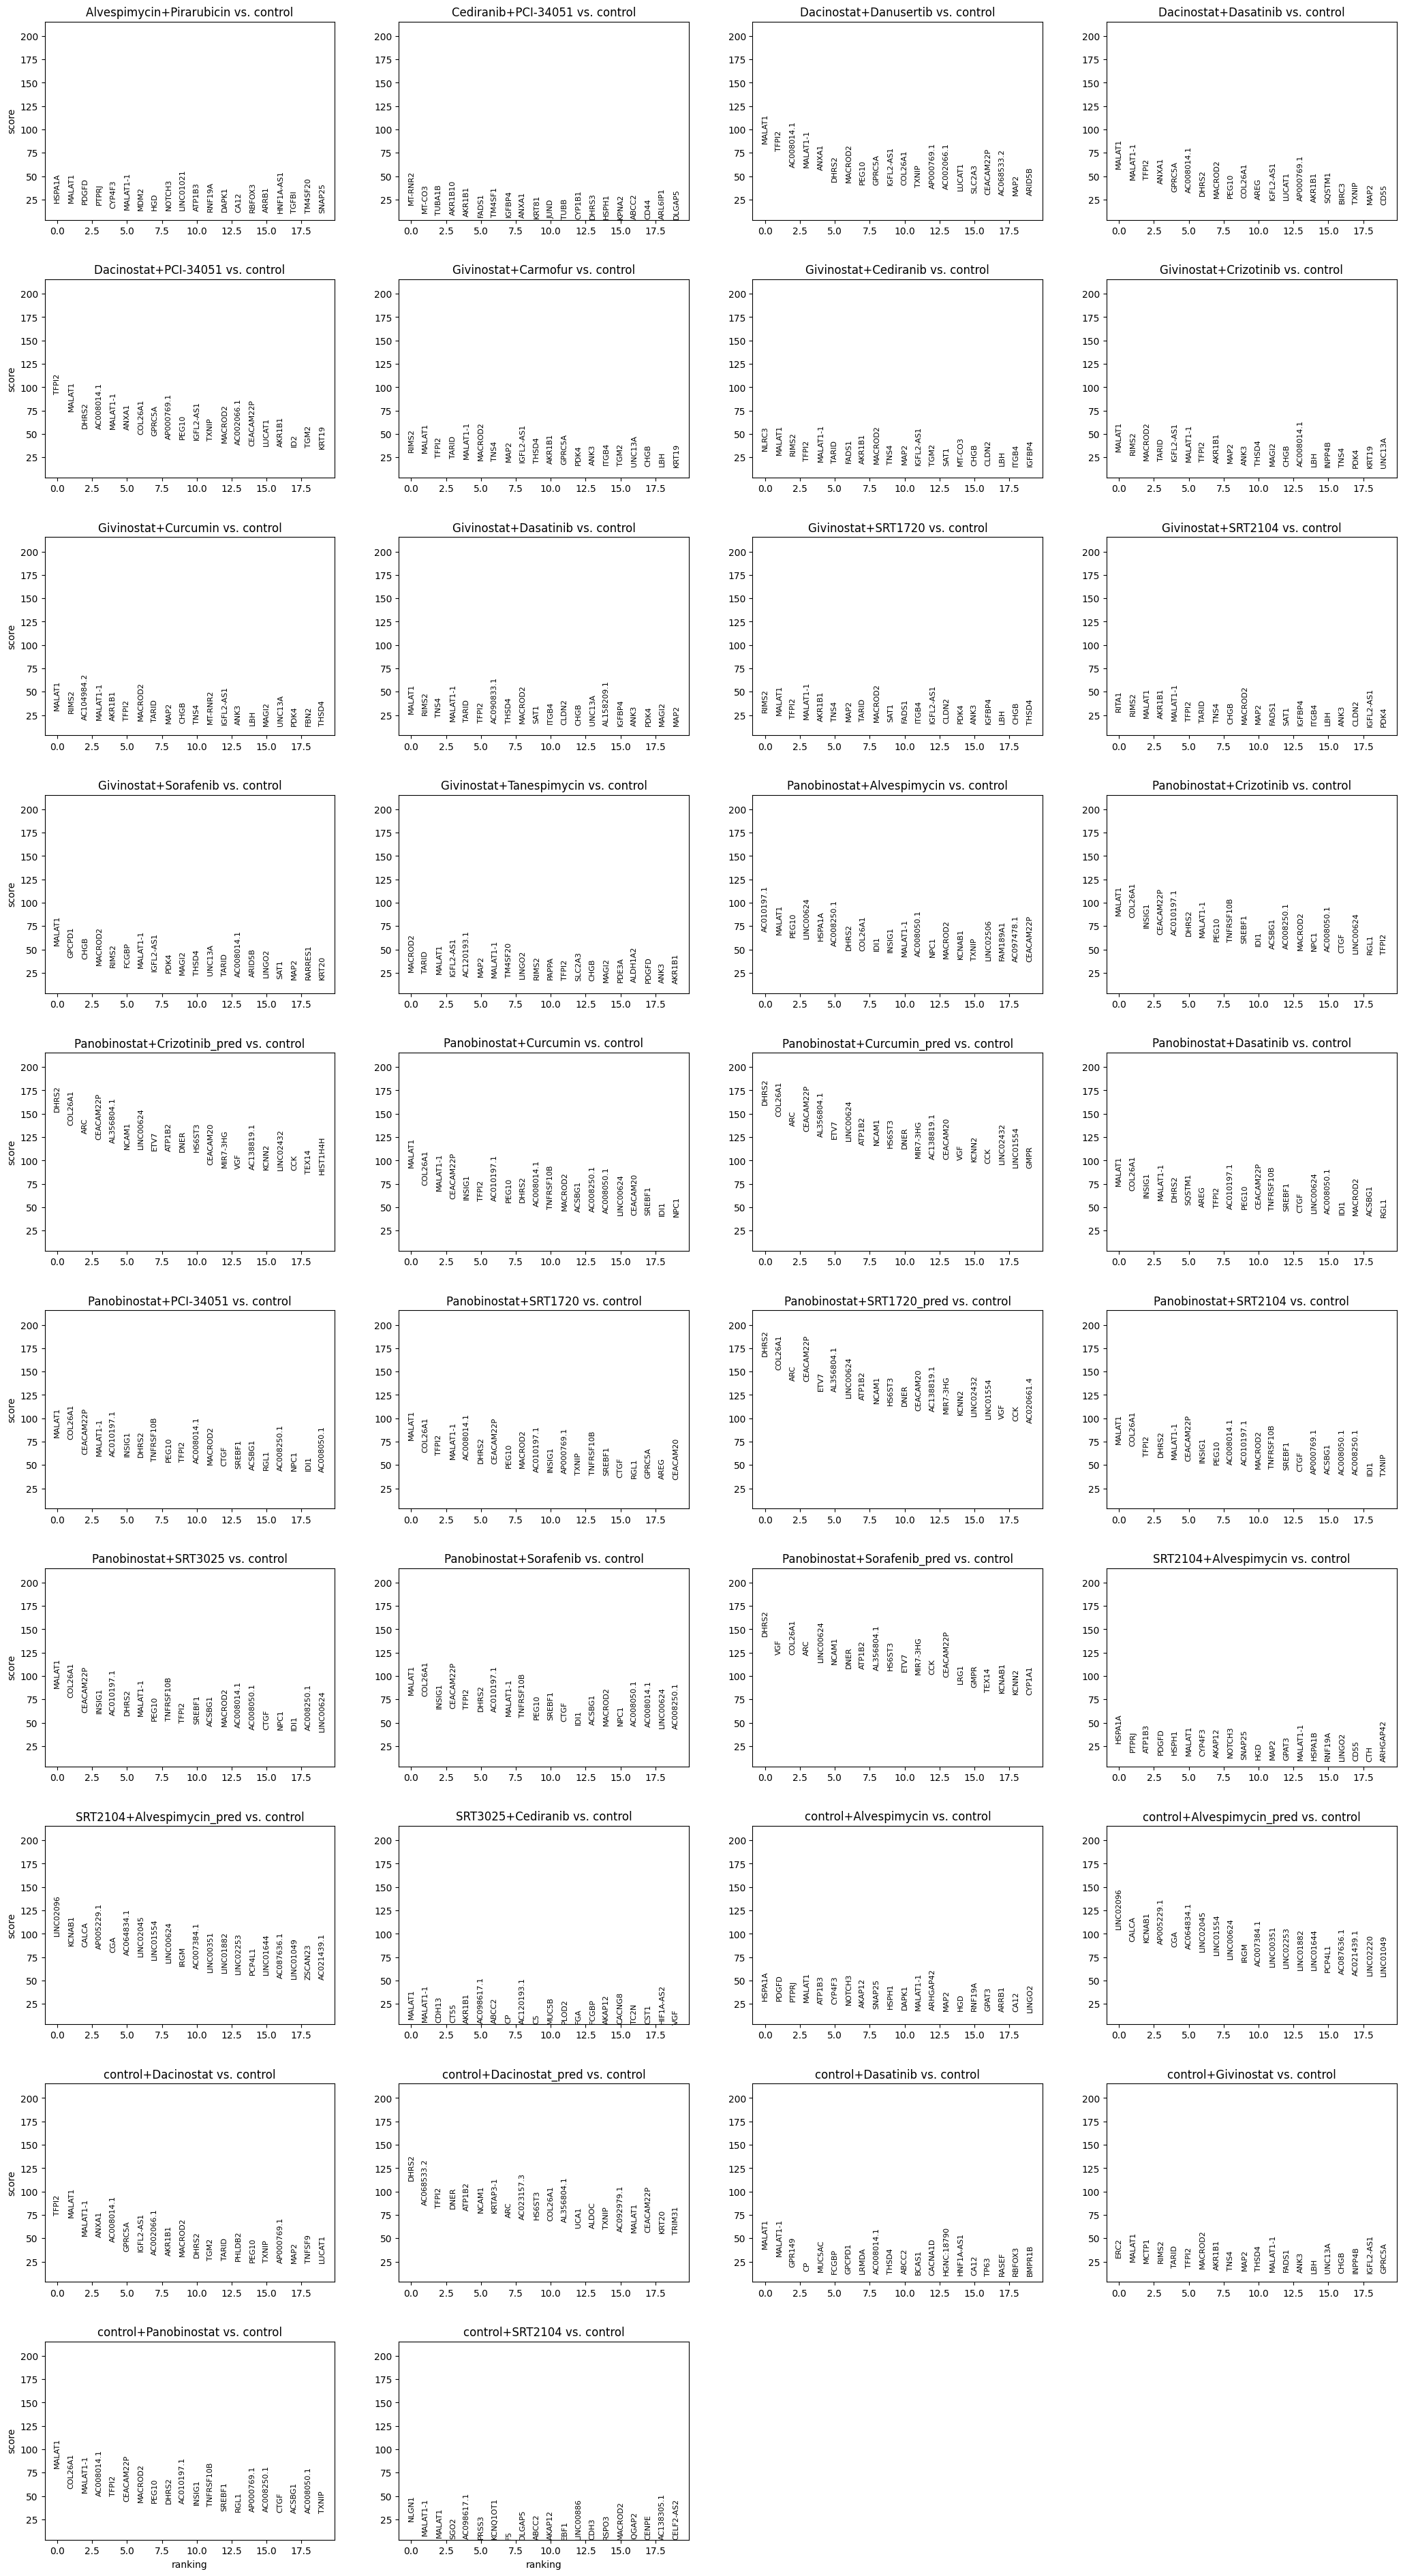

In [16]:
sc.pl.rank_genes_groups(adata_full, key="t-test")

In [17]:
import numpy as np
dict_t_stats = {}

for condition in adata_full.obs["condition"].cat.categories:
    if condition=="control":
        continue
    t_stats = (
        # Get dataframe of DE results for condition vs. rest
        sc.get.rank_genes_groups_df(adata_full, group=condition,  key="t-test")
        .set_index("names")
        # Sort by absolute score
        .sort_values("scores", key=np.abs, ascending=False)
        # Format for decoupler
        [["scores"]]
    )
    dict_t_stats[condition] = t_stats

In [18]:
# Filtering genesets to match behaviour of fgsea
geneset_size = reactome.groupby("geneset").size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

/tmp/ipykernel_84264/1613302725.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  geneset_size = reactome.groupby("geneset").size()


In [19]:
gene_sets_ccnb1_pathway = reactome[reactome["genesymbol"]=="CCNB1"]["geneset"].values

In [47]:
gene_sets_ccnb1_pathway =['REACTOME_INNATE_IMMUNE_SYSTEM']

In [48]:
dict_gsea_results = {}

for condition, t_stats in dict_t_stats.items():
    scores, norm, pvals = decoupler.run_gsea(
        t_stats.T,
        reactome[reactome["geneset"].isin(gene_sets_ccnb1_pathway)],
        source="geneset",
        target="genesymbol",
    )
    gsea_results = (
        pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
        .droplevel(level=1, axis=1)
        .sort_values("pval")
    )
    dict_gsea_results[condition] = gsea_results



In [49]:
dict_gsea_results.keys()

dict_keys(['Alvespimycin+Pirarubicin', 'Cediranib+PCI-34051', 'Dacinostat+Danusertib', 'Dacinostat+Dasatinib', 'Dacinostat+PCI-34051', 'Givinostat+Carmofur', 'Givinostat+Cediranib', 'Givinostat+Crizotinib', 'Givinostat+Curcumin', 'Givinostat+Dasatinib', 'Givinostat+SRT1720', 'Givinostat+SRT2104', 'Givinostat+Sorafenib', 'Givinostat+Tanespimycin', 'Panobinostat+Alvespimycin', 'Panobinostat+Crizotinib', 'Panobinostat+Crizotinib_pred', 'Panobinostat+Curcumin', 'Panobinostat+Curcumin_pred', 'Panobinostat+Dasatinib', 'Panobinostat+PCI-34051', 'Panobinostat+SRT1720', 'Panobinostat+SRT1720_pred', 'Panobinostat+SRT2104', 'Panobinostat+SRT3025', 'Panobinostat+Sorafenib', 'Panobinostat+Sorafenib_pred', 'SRT2104+Alvespimycin', 'SRT2104+Alvespimycin_pred', 'SRT3025+Cediranib', 'control+Alvespimycin', 'control+Alvespimycin_pred', 'control+Dacinostat', 'control+Dacinostat_pred', 'control+Dasatinib', 'control+Givinostat', 'control+Panobinostat', 'control+SRT2104'])

In [50]:
dict_gsea_results['Alvespimycin+Pirarubicin']

,score,norm,pval
source,,,
REACTOME_INNATE_IMMUNE_SYSTEM,0.498185,1.617453,0.010381


In [51]:
'REACTOME_REGULATION_OF_TP53_ACTIVITY_THROUGH_PHOSPHORYLATION' # works
'REACTOME_INNATE_IMMUNE_SYSTEM' # does not work

'REACTOME_REGULATION_OF_TP53_ACTIVITY_THROUGH_PHOSPHORYLATION'

In [52]:
res = {}
res_score = {}
res_norm = {}
for cond, df in dict_gsea_results.items():
    res[cond] = df.loc['REACTOME_INNATE_IMMUNE_SYSTEM']["pval"]
    res_score[cond] = df.loc['REACTOME_INNATE_IMMUNE_SYSTEM']["score"]
    res_norm[cond] = df.loc['REACTOME_INNATE_IMMUNE_SYSTEM']["norm"]

In [54]:
pd.DataFrame(res_score, index=[0]).to_csv(f"gse_score_{split}.csv")

In [34]:
reactome[reactome["geneset"]=='REACTOME_REGULATION_OF_TP53_ACTIVITY_THROUGH_PHOSPHORYLATION']["genesymbol"].value_counts()

genesymbol
AURKA      1
TAF1L      1
TAF2       1
TAF3       1
TAF4       1
          ..
GPR32      0
GPR31      0
GPR3       0
GPR27      0
GPR37L1    0
Name: count, Length: 20046, dtype: int64

In [38]:
[el for el in adata_ood.var_names if "TP" in el]

['ATP1B3',
 'TP63',
 'TPX2',
 'ATP1B2',
 'PTPRJ',
 'PTPRD',
 'PITPNC1',
 'TPPP3',
 'CTPS1',
 'MCTP1',
 'TPRX1',
 'ATP13A5',
 'GRTP1-AS1',
 'ATP6V1G2-DDX39B']

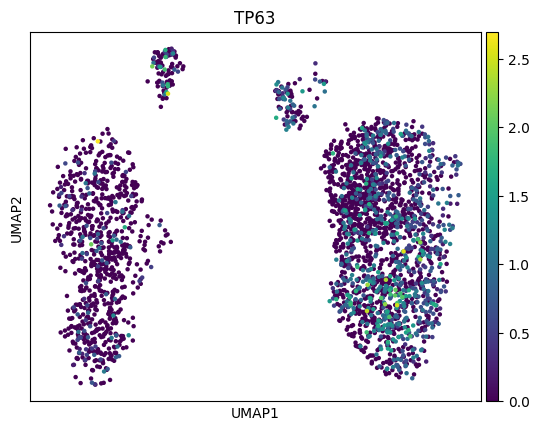

In [42]:
sc.pl.umap(adata_test, color="TP63")

In [92]:
gene_sets = reactome[reactome.genesymbol=="CCNB1"]["geneset"].values

In [93]:
dict_gsea_results = {}

for condition, t_stats in dict_t_stats.items():
    scores, norm, pvals = decoupler.run_gsea(
        t_stats.T,
        reactome[reactome["geneset"].isin(gene_sets)],
        source="geneset",
        target="genesymbol",
    )
    gsea_results = (
        pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
        .droplevel(level=1, axis=1)
        .sort_values("pval")
    )
    dict_gsea_results[condition] = gsea_results



In [106]:
gene_sets

['REACTOME_CONDENSATION_OF_PROMETAPHASE_CHROMOS..., 'REACTOME_RNA_POLYMERASE_II_TRANSCRIPTION', 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN', 'REACTOME_MITOTIC_G2_G2_M_PHASES', 'REACTOME_THE_ROLE_OF_GTSE1_IN_G2_M_PROGRESSIO..., ..., 'REACTOME_G2_M_DNA_DAMAGE_CHECKPOINT', 'REACTOME_ACTIVATION_OF_NIMA_KINASES_NEK9_NEK6..., 'REACTOME_CELL_CYCLE_MITOTIC', 'REACTOME_CONDENSATION_OF_PROPHASE_CHROMOSOMES', 'REACTOME_TRANSCRIPTIONAL_REGULATION_BY_RUNX2']
Length: 39
Categories (33552, string): [AAACCAC_MIR140, AAAGACA_MIR511, AAAGGAT_MIR501, AAAGGGA_MIR204_MIR211, ..., chrXq27, chrXq28, chrYp11, chrYq11]

In [64]:
split = 3
path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_{split}.h5ad"
adata_ood = sc.read(path)
ood_conditions = adata_ood.obs["condition"].cat.categories

In [65]:
ood_conditions

Index(['Panobinostat+Crizotinib', 'Panobinostat+Curcumin',
       'Panobinostat+SRT1720', 'Panobinostat+Sorafenib',
       'SRT2104+Alvespimycin', 'control', 'control+Alvespimycin',
       'control+Dacinostat'],
      dtype='object')

In [94]:
ood_dict = {k:v for k,v in dict_gsea_results.items() if ("pred" in k or k in ood_conditions)}

In [95]:
def get_mode(x):
    if "pred" in x["condition"]:
        return "ood_pred"
    if x["condition"] in ood_conditions:
        return "ood_true"
    return "seen"

In [107]:
df

,0,condition,mode,score
Alvespimycin+Pirarubicin,-0.717632,Alvespimycin+Pirarubicin,seen,-0.717632
Cediranib+PCI-34051,0.455091,Cediranib+PCI-34051,seen,0.455091
Dacinostat+Danusertib,-0.615706,Dacinostat+Danusertib,seen,-0.615706
Dacinostat+Dasatinib,-0.682576,Dacinostat+Dasatinib,seen,-0.682576
Dacinostat+PCI-34051,-0.566566,Dacinostat+PCI-34051,seen,-0.566566
Givinostat+Carmofur,0.571407,Givinostat+Carmofur,seen,0.571407
Givinostat+Cediranib,0.481400,Givinostat+Cediranib,seen,0.481400
Givinostat+Crizotinib,0.488000,Givinostat+Crizotinib,seen,0.488000
Givinostat+Curcumin,0.494255,Givinostat+Curcumin,seen,0.494255
Givinostat+Dasatinib,0.578524,Givinostat+Dasatinib,seen,0.578524


In [101]:
spearman_corrs = {}
for gene_set in gene_sets:
    res_score = {}
    try:
        for cond, df in dict_gsea_results.items():
            res_score[cond] = df.loc[gene_set]["score"]
        df = pd.DataFrame(res_score, index=[0]).T
        df["condition"] = df.index
        df["mode"] = df.apply(get_mode, axis=1)
        df["score"] = df[0]
        df_true = df[df["mode"]=="ood_true"]
        df_pred = df[df["mode"]=="ood_pred"]
        df_true["rank_true"] = df_true["score"].rank()
        df_pred["rank_pred"] = df_pred["score"].rank()
        df_pred["condition"] = df_pred.index
        df_pred["condition"] = df_pred.apply(lambda x: x["condition"].split('_', 1)[0], axis=1)
        df_pred = df_pred.set_index("condition")
        df_res = pd.concat((df_true, df_pred), axis=1)
        spearman_corrs[gene_set] = df_res["rank_true"].corr(df_res["rank_pred"], method="spearman")
    except KeyError:
        print(gene_set)
        

REACTOME_CONDENSATION_OF_PROMETAPHASE_CHROMOSOMES
REACTOME_NUCLEAR_ENVELOPE_NE_REASSEMBLY
REACTOME_NUCLEAR_PORE_COMPLEX_NPC_DISASSEMBLY
REACTOME_PHOSPHORYLATION_OF_EMI1
REACTOME_GOLGI_CISTERNAE_PERICENTRIOLAR_STACK_REORGANIZATION
REACTOME_MASTL_FACILITATES_MITOTIC_PROGRESSION
REACTOME_PHOSPHORYLATION_OF_THE_APC_C
REACTOME_INITIATION_OF_NUCLEAR_ENVELOPE_NE_REFORMATION
REACTOME_TP53_REGULATES_TRANSCRIPTION_OF_CELL_CYCLE_GENES
REACTOME_POLO_LIKE_KINASE_MEDIATED_EVENTS
REACTOME_G2_M_DNA_REPLICATION_CHECKPOINT
REACTOME_CHK1_CHK2_CDS1_MEDIATED_INACTIVATION_OF_CYCLIN_B_CDK1_COMPLEX
REACTOME_TP53_REGULATES_TRANSCRIPTION_OF_GENES_INVOLVED_IN_G2_CELL_CYCLE_ARREST
REACTOME_DEPOLYMERISATION_OF_THE_NUCLEAR_LAMINA
REACTOME_CYCLIN_A_B1_B2_ASSOCIATED_EVENTS_DURING_G2_M_TRANSITION
REACTOME_E2F_ENABLED_INHIBITION_OF_PRE_REPLICATION_COMPLEX_FORMATION
REACTOME_APC_C_CDC20_MEDIATED_DEGRADATION_OF_CYCLIN_B
REACTOME_APC_C_MEDIATED_DEGRADATION_OF_CELL_CYCLE_PROTEINS
REACTOME_E2F_MEDIATED_REGULATION_OF_DNA_REP

/tmp/ipykernel_84264/2008434611.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_true["rank_true"] = df_true["score"].rank()
/tmp/ipykernel_84264/2008434611.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred["rank_pred"] = df_pred["score"].rank()
/tmp/ipykernel_84264/2008434611.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [98]:
np.mean(spearman_corrs)

0.4730122979397563

In [102]:
spearman_corrs

{'REACTOME_RNA_POLYMERASE_II_TRANSCRIPTION': -0.10714285714285716,
 'REACTOME_NUCLEAR_ENVELOPE_BREAKDOWN': -0.21428571428571433,
 'REACTOME_MITOTIC_G2_G2_M_PHASES': 0.8214285714285715,
 'REACTOME_THE_ROLE_OF_GTSE1_IN_G2_M_PROGRESSION_AFTER_G2_CHECKPOINT': 0.792824967172092,
 'REACTOME_REGULATION_OF_PLK1_ACTIVITY_AT_G2_M_TRANSITION': 0.792824967172092,
 'REACTOME_MITOTIC_METAPHASE_AND_ANAPHASE': 0.7857142857142859,
 'REACTOME_G2_M_CHECKPOINTS': 0.1785714285714286,
 'REACTOME_MITOTIC_G1_PHASE_AND_G1_S_TRANSITION': 0.3214285714285715,
 'REACTOME_MITOTIC_PROMETAPHASE': 0.6785714285714287,
 'REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53': 0.42857142857142866,
 'REACTOME_M_PHASE': 0.3214285714285715,
 'REACTOME_MITOTIC_PROPHASE': 0.3571428571428572,
 'REACTOME_RESOLUTION_OF_SISTER_CHROMATID_COHESION': 0.7500000000000002,
 'REACTOME_CELL_CYCLE': 0.6785714285714287,
 'REACTOME_CELL_CYCLE_CHECKPOINTS': 0.7500000000000002,
 'REACTOME_G2_M_DNA_DAMAGE_CHECKPOINT': 0.42857142857142866,
 'REACTOME_CEL

In [103]:
dict_gsea_results.keys()

dict_keys(['Alvespimycin+Pirarubicin', 'Cediranib+PCI-34051', 'Dacinostat+Danusertib', 'Dacinostat+Dasatinib', 'Dacinostat+PCI-34051', 'Givinostat+Carmofur', 'Givinostat+Cediranib', 'Givinostat+Crizotinib', 'Givinostat+Curcumin', 'Givinostat+Dasatinib', 'Givinostat+SRT1720', 'Givinostat+SRT2104', 'Givinostat+Sorafenib', 'Givinostat+Tanespimycin', 'Panobinostat+Alvespimycin', 'Panobinostat+Crizotinib', 'Panobinostat+Crizotinib_pred', 'Panobinostat+Curcumin', 'Panobinostat+Curcumin_pred', 'Panobinostat+Dasatinib', 'Panobinostat+PCI-34051', 'Panobinostat+SRT1720', 'Panobinostat+SRT1720_pred', 'Panobinostat+SRT2104', 'Panobinostat+SRT3025', 'Panobinostat+Sorafenib', 'Panobinostat+Sorafenib_pred', 'SRT2104+Alvespimycin', 'SRT2104+Alvespimycin_pred', 'SRT3025+Cediranib', 'control+Alvespimycin', 'control+Alvespimycin_pred', 'control+Dacinostat', 'control+Dacinostat_pred', 'control+Dasatinib', 'control+Givinostat', 'control+Panobinostat', 'control+SRT2104'])

In [104]:
dict_gsea_results['Panobinostat+Curcumin_pred']

,score,norm,pval
source,,,
REACTOME_CELL_CYCLE,-0.754254,-3.884787,0.000000
REACTOME_CELL_CYCLE_CHECKPOINTS,-0.920127,-3.581971,0.000000
REACTOME_CELL_CYCLE_MITOTIC,-0.759792,-3.578684,0.000000
REACTOME_G2_M_CHECKPOINTS,-0.931017,-3.086799,0.000000
REACTOME_G2_M_DNA_DAMAGE_CHECKPOINT,-0.953360,-2.203306,0.000000
REACTOME_MITOTIC_G1_PHASE_AND_G1_S_TRANSITION,-0.930080,-2.837066,0.000000
REACTOME_MITOTIC_G2_G2_M_PHASES,-0.881261,-2.817768,0.000000
REACTOME_MITOTIC_METAPHASE_AND_ANAPHASE,-0.889477,-3.033964,0.000000
REACTOME_MITOTIC_PROMETAPHASE,-0.901496,-3.081467,0.000000
